# The Battle of Neighborhoods

### Business Problem

A group of investors were planning to open an American restaurant in New York City. They wanted to know where is the best location for an American restaurant with least compeition. Based on this requirement, we will use data science tools and techniques to analyze data collected on borough and neighborhood and venues with category in American restaurants in New York City. We will try to find the optimal location for the American restaurant business using the analysis.

### Data section

Borough and neighborhood data for New York City is retrieved from https://cocl.us/new_york_dataset which was provided by Coursera. Also this includes latitude and longitude information.

To explore and target recommended location in New York City for restaurants business, we will access data through FourSquare API interface and arrange them as a dataframe for visualization. By merging data on borough and neighborhood data with venue details for American restaurants from FourSquare API interface, we will be able to recommend profitable restaurant investments.

### Let the code begins...

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Libaries Imported!')

Libaries Imported!


##### Function to get the latitude and longitude of a given location using geopy

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [3]:
radius=1000
LIMIT=100
CLIENT_ID = 'BPMFIEXXXXXXXXXXXXXXXXXXXXXXXXXXXXMT1GPKCETSINV'           # your Foursquare ID
CLIENT_SECRET = 'MTBKWV5TXXXXXXXXXXXXXXXXXXXXXXXXXXXCCXYI0TVXOIJ'       # your Foursquare Secret
VERSION = '20200402'                                                     # Foursquare API version

#### Function to intract with FourSquare API and extract top 100 venues within a radius of 1000 metres for a given latitude and longitude

In [4]:
def get_venues(lat,lng):
    
    #set variables
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
    
    # get all the data
    results = requests.get(url).json()

    if (results["response"] != None and results["response"]['groups'] != None):
        venue_data=results["response"]['groups'][0]['items']
        venue_details=[]
        for row in venue_data:
            try:
                venue_id=row['venue']['id']
                venue_name=row['venue']['name']
                venue_category=row['venue']['categories'][0]['name']
                venue_details.append([venue_id,venue_name,venue_category])
            except KeyError:
                pass

        column_names=['ID','Name','Category']
        df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### Function to get venue details like like count , rating , tip counts for a given venue id

In [5]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(venue_id,CLIENT_ID,CLIENT_SECRET,VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### Funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

#### get new york data

In [7]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

#### We can visualize this neighbrohood

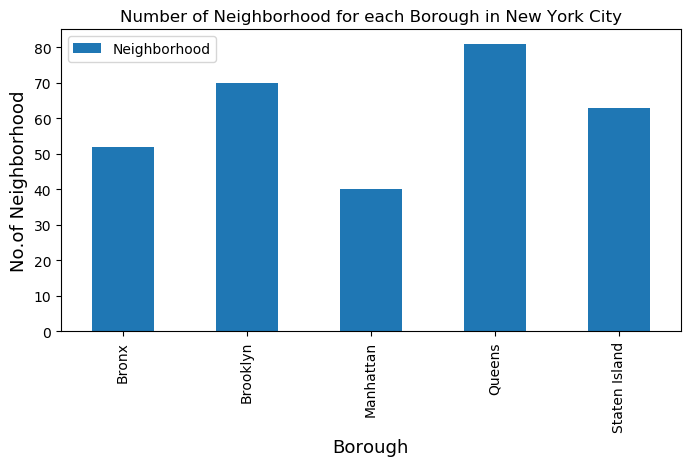

In [9]:
plt.figure(figsize=(8,4), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 13)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=13)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect American resturants for each Neighborhood

In [10]:
# prepare neighborhood list that contains American resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
amer_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    amer_resturants=venues[venues['Category']=='American Restaurant']   
    for resturant_detail in amer_resturants.values.tolist():
        id, name , category=resturant_detail
        amer_rest_ny = amer_rest_ny.append({'Borough': Borough,'Neighborhood': Neighborhood,'ID': id,'Name' : name},ignore_index=True)
    count+=1

In [11]:
amer_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,4bb0ebe3f964a5205c6a3ce3,Applebee's Grill + Bar
1,Bronx,Kingsbridge,585c205665e7c70a2f1055ea,Boston Market
2,Manhattan,Marble Hill,585c205665e7c70a2f1055ea,Boston Market
3,Bronx,Woodlawn,4c543dd2728920a1ce756c82,Irish Coffee Shop
4,Bronx,Norwood,4b8d440bf964a520c8f032e3,vip


In [12]:
amer_rest_ny.shape

(319, 4)

In [43]:
# save the dataset since we are limited to 500 calls to Foursquare daily
amer_rest_ny.to_csv('amer_rest_ny.csv', index=False)
amer_rest_ny=pd.read_csv('amer_rest_ny.csv',engine='python')
amer_rest_ny.shape

(319, 4)

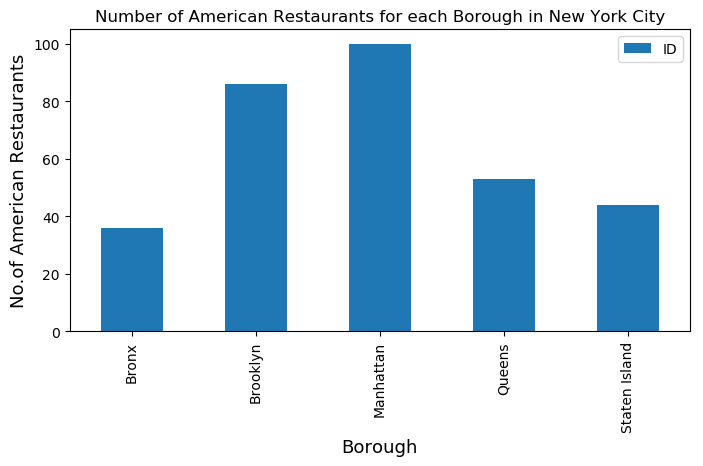

In [16]:
plt.figure(figsize=(8,4), dpi = 100)
# title
plt.title('Number of American Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 13)
#On y-axis
plt.ylabel('No.of American Restaurants', fontsize=13)
#giving a bar plot
amer_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### We see that Manhattan and Brooklyn has the largest number of American resturants

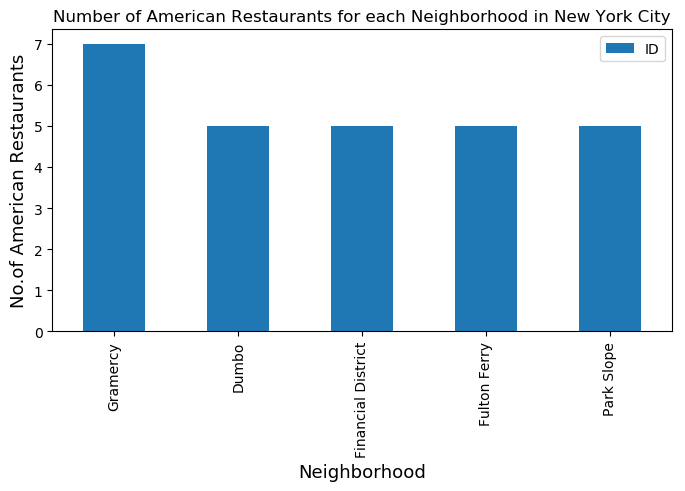

In [17]:
plt.figure(figsize=(8,4), dpi = 100)
# title
plt.title('Number of American Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 13)
#On y-axis
plt.ylabel('No.of American Restaurants', fontsize=13)
#giving a bar plot
amer_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [18]:
print(amer_rest_ny[amer_rest_ny['Neighborhood']=='Gramercy'].shape)
amer_rest_ny[amer_rest_ny['Neighborhood']=='Gramercy']

(7, 4)


,Borough,Neighborhood,ID,Name
156,Manhattan,Gramercy,5a5ec2e4bb8d3614bb5d49f5,Simon & The Whale
157,Manhattan,Gramercy,3fd66200f964a520aee91ee3,Gramercy Tavern
158,Manhattan,Gramercy,3fd66200f964a52080e41ee3,Craft
159,Manhattan,Gramercy,4a01d7b8f964a52001711fe3,Hillstone
160,Manhattan,Gramercy,541c9b0f498e5719ff8129f8,Park Avenue Autumn/Winter/Spring/Summer
161,Manhattan,Gramercy,5536759a498e56e343077057,Dig Inn
162,Manhattan,Gramercy,4e1a41d3183880768f53f08c,The Cellar at Beecher's


So Gramercy in Manhattan has the highest number of American Resturants with a total count of 7.

Now we will get the ranking of each restaurant for further analysis.

In [19]:
print(amer_rest_ny[amer_rest_ny['Neighborhood']=='Park Slope'].shape)
amer_rest_ny[amer_rest_ny['Neighborhood']=='Park Slope']

(5, 4)


,Borough,Neighborhood,ID,Name
65,Brooklyn,Park Slope,3fd66200f964a52082f11ee3,Rose Water
66,Brooklyn,Park Slope,4e45bca962845e1d3c88924e,Kiwiana
67,Brooklyn,Park Slope,4aa5af70f964a520294920e3,Stone Park Café
68,Brooklyn,Park Slope,49c86272f964a52019581fe3,Bonnie's Grill
69,Brooklyn,Park Slope,3fd66200f964a52078f11ee3,Blue Ribbon Brasserie


In [20]:
print(amer_rest_ny[amer_rest_ny['Neighborhood']=='West Village'].shape)
amer_rest_ny[amer_rest_ny['Neighborhood']=='West Village']

(5, 4)


,Borough,Neighborhood,ID,Name
146,Manhattan,West Village,3fd66200f964a52040e71ee3,Westville West
147,Manhattan,West Village,45379ccef964a520c13b1fe3,The Little Owl
148,Manhattan,West Village,4ca21faa8afca09388192116,Jeffrey's Grocery
149,Manhattan,West Village,49bf289bf964a5200a551fe3,Cafe Cluny
150,Manhattan,West Village,5201a363498ed3d5217949ba,The Grey Dog - West Village


In [21]:
# prepare neighborhood list that contains American restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
amer_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in amer_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    amer_rest_stats_ny = amer_rest_stats_ny.append({'Borough': Borough,'Neighborhood': Neighborhood,'ID': id,'Name' : name,'Likes' : likes,'Rating' : rating,'Tips' : tips}, ignore_index=True)
    count+=1

                         ID                    Name  Likes  Rating  Tips
0  4bb0ebe3f964a5205c6a3ce3  Applebee's Grill + Bar     67     6.2    37
                         ID           Name  Likes  Rating  Tips
0  585c205665e7c70a2f1055ea  Boston Market      4     6.9     1
                         ID           Name  Likes  Rating  Tips
0  585c205665e7c70a2f1055ea  Boston Market      4     6.9     1
                         ID               Name  Likes  Rating  Tips
0  4c543dd2728920a1ce756c82  Irish Coffee Shop     24     7.5     4
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4b8d440bf964a520c8f032e3
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e6e2faad4c0af8b795d3807
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e4df7a3bd4101d0d79f4699
                         ID         Name  Likes  Rating  Tips
0  45164517f964a5200a3a1fe3  Black Whale     3

KeyError: 'venue'

In [22]:
amer_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,4bb0ebe3f964a5205c6a3ce3,Applebee's Grill + Bar,67,6.2,37
1,Bronx,Kingsbridge,585c205665e7c70a2f1055ea,Boston Market,4,6.9,1
2,Manhattan,Marble Hill,585c205665e7c70a2f1055ea,Boston Market,4,6.9,1
3,Bronx,Woodlawn,4c543dd2728920a1ce756c82,Irish Coffee Shop,24,7.5,4
4,Bronx,Norwood,0,0,0,0.0,0


In [23]:
amer_rest_stats_ny.shape

(50, 7)

In [25]:
# save the dataset since we are limited to 500 calls to Foursquare daily
amer_rest_stats_ny.to_csv('amer_rest_stats_ny.csv', index=False)
amer_rest_stats_ny = pd.read_csv('amer_rest_stats_ny.csv',engine='python')

In [27]:
print(amer_rest_stats_ny.shape)
amer_rest_stats_ny.head()

(50, 7)


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,4bb0ebe3f964a5205c6a3ce3,Applebee's Grill + Bar,67,6.2,37
1,Bronx,Kingsbridge,585c205665e7c70a2f1055ea,Boston Market,4,6.9,1
2,Manhattan,Marble Hill,585c205665e7c70a2f1055ea,Boston Market,4,6.9,1
3,Bronx,Woodlawn,4c543dd2728920a1ce756c82,Irish Coffee Shop,24,7.5,4
4,Bronx,Norwood,0,0,0,0.0,0


In [28]:
amer_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null int64
Rating          50 non-null float64
Tips            50 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 2.8+ KB


#### We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [29]:
amer_rest_stats_ny['Likes']=amer_rest_stats_ny['Likes'].astype('float64')
amer_rest_stats_ny['Tips']=amer_rest_stats_ny['Tips'].astype('float64')

In [30]:
# Resturant with maximum Likes
amer_rest_stats_ny.iloc[amer_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                Williamsburg
ID              49c3df11f964a52081561fe3
Name                       Walter Sports
Likes                                743
Rating                               8.8
Tips                                 253
Name: 48, dtype: object

In [31]:
# Resturant with maximum Tips
amer_rest_stats_ny.iloc[amer_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                Williamsburg
ID              4176fc00f964a520b21d1fe3
Name                       Marlow & Sons
Likes                                692
Rating                               8.8
Tips                                 255
Name: 49, dtype: object

In [32]:
# Resturant with maximum Rating
amer_rest_stats_ny.iloc[amer_rest_stats_ny['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                 Throgs Neck
ID              4bf471c198ac0f47190664a8
Name                  Muscle Maker Grill
Likes                                 44
Rating                               9.1
Tips                                  19
Name: 13, dtype: object

In [33]:
ny_neighborhood_stats=amer_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [34]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
26,Throgs Neck,9.100000
8,Edgewater Park,9.100000
10,Greenpoint,8.800000
30,Williamsburg,8.800000
31,Windsor Terrace,8.666667
11,Kensington,8.500000
6,Country Club,8.400000
0,Bay Ridge,8.366667
23,Schuylerville,8.100000
22,Prospect Heights,7.800000


#### These are the top Neighborhoods with top average rating of American restaurants

In [35]:
ny_borough_stats=amer_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [36]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,8.156250
2,Manhattan,6.900000
0,Bronx,5.593939


Similarly these are the average rating of American Resturants for each Borough

Lets visualize it

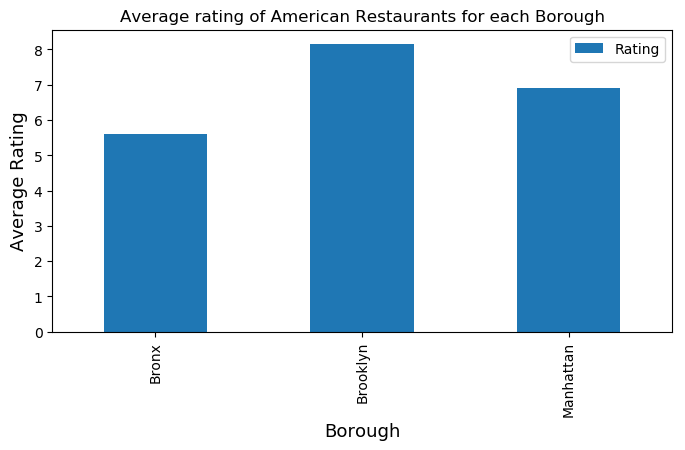

In [37]:
plt.figure(figsize=(8,4), dpi = 100)
# title
plt.title('Average rating of American Restaurants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 13)
#On y-axis
plt.ylabel('Average Rating', fontsize=13)
#giving a bar plot
amer_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [38]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
8,Edgewater Park,9.1
26,Throgs Neck,9.1


#### We will join this dataset to original new york data to get lonitude and latitude

In [39]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Edgewater Park,40.821986,-73.813885,9.1
1,Bronx,Throgs Neck,40.815109,-73.816350,9.1


#### Display this data on a map

In [40]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(folium.CircleMarker([lat, lng],radius=10,color='yellow',fill=True,fill_color='blue',fill_opacity=0.6))

Lets add a new field to dataframe for labeling purpose

In [41]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [42]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

### Conclusion

Manhattan and Brooklyn have the best rated American restaurants on average. Queens and The Bronx have the least amount of American restaurants per borough. Gramercy of Manhattan is the neighborhood with the most American Restaurants. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most American restaurants. Based on this information, I would state that Bronx and Queens are the best locations for American cuisine in NYC. To have the best shot of success, I would open an American restaurant in Queens. Queens has most neighborhoods in NYC but with least number of American restaurants. I think it will be less competition for business to open an American restaurant.